## TODO
- start med student har samme arkitæktur som ensemble (kinda done)
- fix some of the plots for the ensemble that broke (i think they broke when changing size of the ensemble and or epochs)
- do more comparative analysis of the student model and ensemble

- Try with the imdb dataet (DONE)
- Split the train set fo sst to test and train sets (DONE)
- Incorperate early stopping during training
- Simplify the loss function for distillation so there is less parameters
- Make a combinded ECE Plot
- Test on the the training set

# Embed dataset:

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import warnings 

# Check for GPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS device')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA device')
else:
    device = torch.device('cpu')
    print('No GPU found. Using CPU')


from utils import *
from train import *


/opt/miniconda3/envs/nlp-project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MPS device
Using MPS device


# Eval function

## Process embeddings and labels

In [2]:
train_embeddings_file='train_embeddings.npy'
train_labels_file='train_labels.npy'
validation_embeddings_file='validation_embeddings.npy'
validation_labels_file='validation_labels.npy'
test_embeddings_file='test_embeddings.npy'
test_labels_file='test_labels.npy'

# Load embeddings and labels from disk
train_em = np.load(train_embeddings_file)
train_la = np.load(train_labels_file)
val_em = np.load(validation_embeddings_file)
val_la = np.load(validation_labels_file)
test_em = np.load(test_embeddings_file)
test_la = np.load(test_labels_file)
print("Loaded train, validation, and test embeddings and labels from disk.")

Loaded train, validation, and test embeddings and labels from disk.


In [3]:
imdb_train_embeddings_file='imdb_long_train_em.npy'
imdb_train_labels_file='imdb_long_train_la.npy'
imdb_test_embeddings_file='imdb_long_test_em.npy'
imdb_test_labels_file='imdb_long_test_la.npy'
imdb_unsupervised_embeddings_file='imdb_long_unsuper_em.npy'
imdb_unsupervised_labels_file='imdb_long_unsuper_la.npy'

imdb_train_em = np.load(imdb_train_embeddings_file)
imdb_train_la = np.load(imdb_train_labels_file)
imdb_test_em = np.load(imdb_test_embeddings_file)
imdb_test_la = np.load(imdb_test_labels_file)
imdb_unsuper_em = np.load(imdb_unsupervised_embeddings_file)
imdb_unsuper_la = np.load(imdb_unsupervised_labels_file)
print("Loaded train, test, and unsupervised embeddings and labels from disk.")

Loaded train, test, and unsupervised embeddings and labels from disk.


In [4]:
scaler = StandardScaler()
train_em = scaler.fit_transform(train_em)
val_em = scaler.transform(val_em)
test_em = scaler.transform(test_em)
imdb_train_em = scaler.transform(imdb_train_em)
imdb_test_em = scaler.transform(imdb_test_em)
imdb_unsuper_em = scaler.transform(imdb_unsuper_em)


In [5]:
train_em, test_em, train_la, test_la = train_test_split(
        train_em, 
        train_la, 
        test_size=0.20,       # This specifies that 20% of the data goes to the distil
        random_state=42,      # Ensures reproducibility
        stratify=train_la # Ensures that the class distribution is preserved
    )

print(f"Train embeddings shape: {train_em.shape}")
print(f"Train labels shape: {train_la.shape}")
print(f"Val embeddings shape: {test_em.shape}")
print(f"Val labels shape: {test_la.shape}")

Train embeddings shape: (53879, 2048)
Train labels shape: (53879,)
Val embeddings shape: (13470, 2048)
Val labels shape: (13470,)


# Ensemble training

Har gjort MLPen dybere for at den ikke overfitter i distillation

In [6]:
class MLP(nn.Module):
        def __init__(self, input_dim, hidden_dim1=512, hidden_dim2=64, output_size=2):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim1)
            self.dropout1 = nn.Dropout(p=0.5)
            self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
            self.dropout2 = nn.Dropout(p=0.5)
            self.fc3 = nn.Linear(hidden_dim2, output_size)
        
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.dropout1(x)
            x = torch.relu(self.fc2(x))
            x = self.dropout2(x)
            x = self.fc3(x)
            return x


Training MLP 1/100
Epoch 1 -- Train Loss: 0.3621, Val Loss: 0.3304
Epoch 2 -- Train Loss: 0.2698, Val Loss: 0.3123
Epoch 3 -- Train Loss: 0.2357, Val Loss: 0.3244
Epoch 4 -- Train Loss: 0.2100, Val Loss: 0.3724
Epoch 5 -- Train Loss: 0.1922, Val Loss: 0.3508
Early stopping for this model triggered at epoch 5.
Model 1: Accuracy = 0.8670, NLL = 0.3508, ECE = 0.0472, F1 = 0.8667
Ensemble Size 1 -- Accuracy: 0.8670, NLL: 0.3508, ECE: 0.0472, F1: 0.8667
Ensemble performance improved (NLL or ECE decreased, ACC or F1 increased).

Training MLP 2/100
Epoch 1 -- Train Loss: 0.3582, Val Loss: 0.3537
Epoch 2 -- Train Loss: 0.2704, Val Loss: 0.3288
Epoch 3 -- Train Loss: 0.2387, Val Loss: 0.3361
Epoch 4 -- Train Loss: 0.2131, Val Loss: 0.3615
Epoch 5 -- Train Loss: 0.1945, Val Loss: 0.3596
Early stopping for this model triggered at epoch 5.
Model 2: Accuracy = 0.8635, NLL = 0.3596, ECE = 0.0596, F1 = 0.8634
Ensemble Size 2 -- Accuracy: 0.8635, NLL: 0.3426, ECE: 0.0470, F1: 0.8634
Ensemble performa

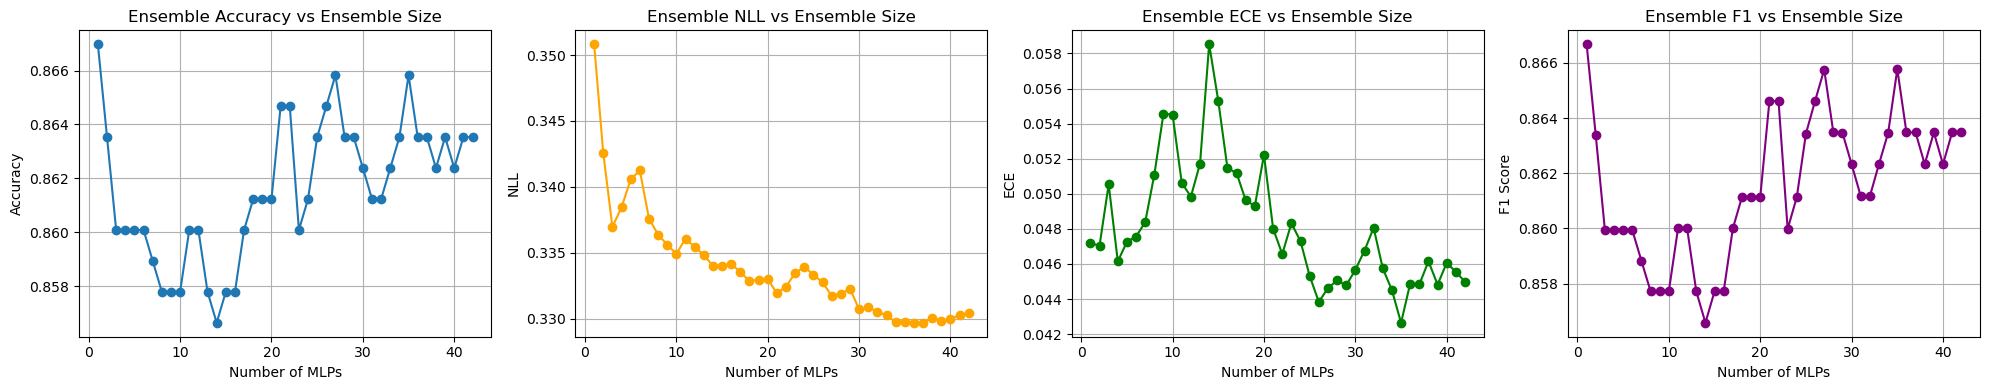

In [7]:
ensemble_models, metrics, ensemble_probs, individual_metrics = train_ensemble_with_early_stopping(train_em, train_la,
                                    val_em, val_la, MLP=MLP,
                                    N=100, batch_size=1024, epochs=20,
                                    model_patience=3,
                                    ensemble_patience=3)

### The method used above for ensemble prediction is averaging (Mean Voting)
   - **Description**: Each MLP produces a probability distribution over classes or a continuous output. The ensemble output is the average of these predictions.
   - **Application**: Commonly used for regression tasks or classification tasks where probabilities are averaged.
   - **Pros**: Simple to implement; works well when individual models are reasonably accurate and diverse.
   - **Cons**: Does not account for cases where some models are more accurate than others.


In [8]:
all_probs = ensemble_probs['probs']

# Predictive mean (averaged probabilities)
mean_probs = ensemble_probs['mean']

# Predictive variance (epistemic uncertainty)
variance_probs = ensemble_probs['var']

# Predictive entropy
entropy = ensemble_probs['entropy']


## Predictive Variance Histogram
Purpose: To see the distribution of uncertainties across all predictions.


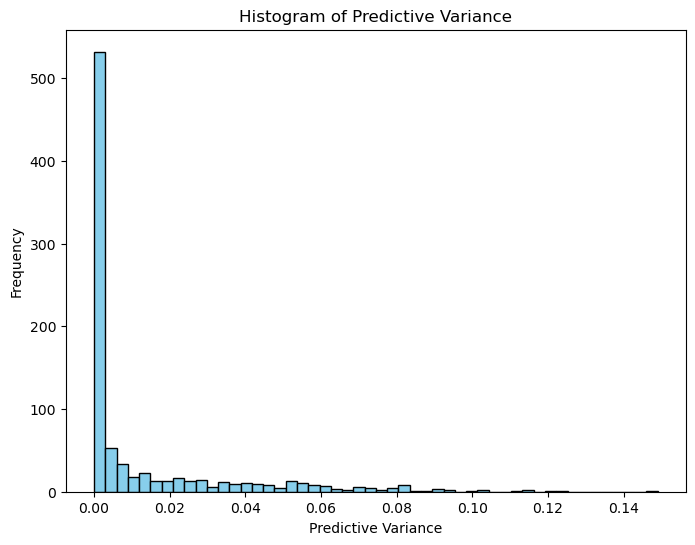

In [9]:
# Sum variances across classes if multi-class (for overall uncertainty)
total_variance = np.sum(variance_probs, axis=1)

plt.figure(figsize=(8, 6))
plt.hist(total_variance, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Predictive Variance')
plt.xlabel('Predictive Variance')
plt.ylabel('Frequency')
plt.show()





## Predictive Entropy Histogram
Purpose: Similar to variance, entropy gives a sense of uncertainty in predictions.



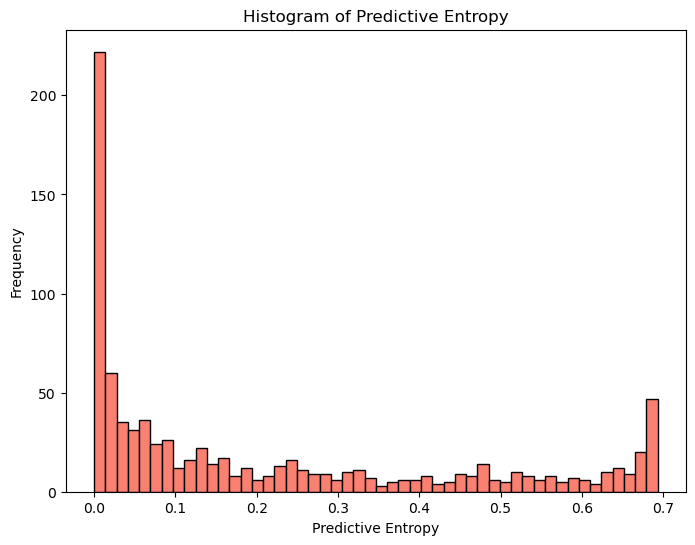

In [10]:

plt.figure(figsize=(8, 6))
plt.hist(entropy, bins=50, color='salmon', edgecolor='black')
plt.title('Histogram of Predictive Entropy')
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.show()



## Scatter Plots of Uncertainty vs. Confidence

Purpose: To observe the relationship between model confidence and uncertainty.



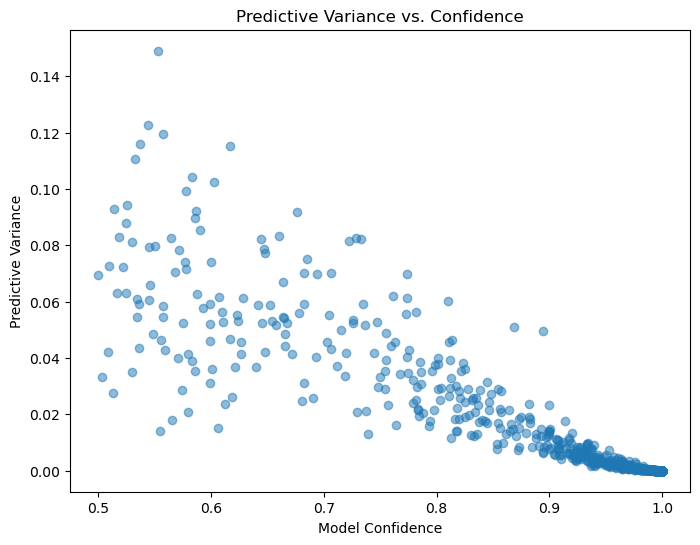

In [11]:

# Model confidence: max probability from mean_probs
confidence = np.max(mean_probs, axis=1)

# Total variance or entropy as uncertainty measure
total_variance = np.sum(variance_probs, axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(confidence, total_variance, alpha=0.5)
plt.title('Predictive Variance vs. Confidence')
plt.xlabel('Model Confidence')
plt.ylabel('Predictive Variance')
plt.show()



## Uncertainty vs. Correctness
Purpose: To check if higher uncertainties correspond to incorrect predictions.



In [12]:
# # Predicted labels
# predicted_labels = np.argmax(mean_probs, axis=1)

# # True labels
# true_labels = val_y.numpy()

# # Correct predictions
# correct = (predicted_labels == true_labels)

# # Total variance or entropy
# total_variance = np.sum(variance_probs, axis=1)

# plt.figure(figsize=(8, 6))
# plt.scatter(total_variance, correct, alpha=0.5, c=correct, cmap='bwr')
# plt.title('Predictive Variance vs. Correctness')
# plt.xlabel('Predictive Variance')
# plt.ylabel('Correct Prediction (1=True, 0=False)')
# plt.show()


## Reliability Diagram (Calibration Curve)
Purpose: To assess how well the predicted probabilities are calibrated.



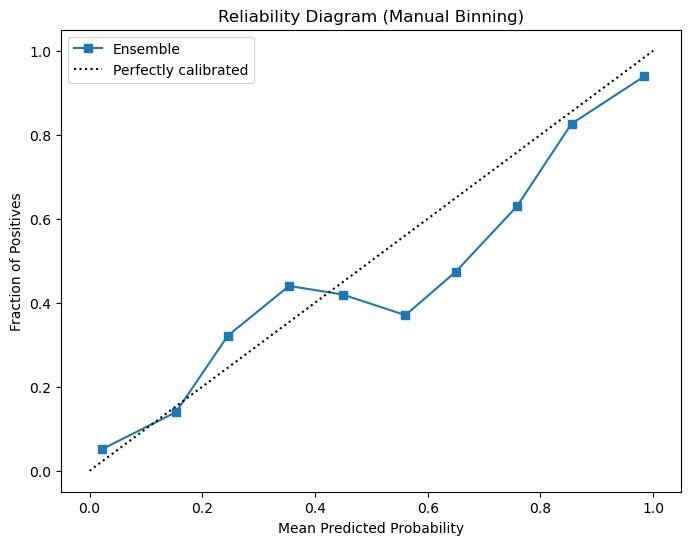

Bin counts: [290.  43.  28.  25.  31.  27.  19.  27.  46. 327.]


In [13]:
# Assume ensemble_probs is computed in your training loop as the averaged probability outputs on the validation set.
ensemble_prob_pos = mean_probs[:, 1]  # Extract probability for positive class
val_y = torch.from_numpy(val_la).long()
plot_reliability_diagram(ensemble_prob_pos, val_y.numpy(), n_bins=10)

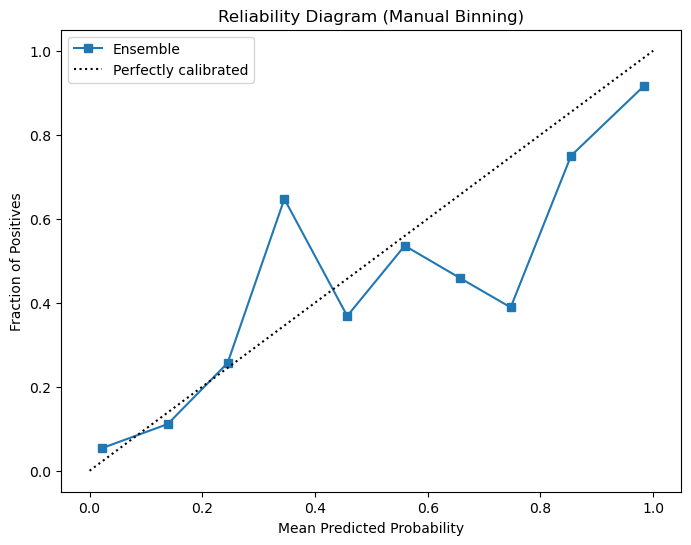

Bin counts: [280.  45.  39.  17.  19.  28.  24.  18.  36. 355.]


In [14]:
# Assume ensemble_probs is computed in your training loop as the averaged probability outputs on the validation set.

single_probs = all_probs[5]
single_prob_pos = single_probs[:, 1]  # Extract probability for positive class
plot_reliability_diagram(single_prob_pos, val_y.numpy(), n_bins=10)


## Misclassification vs. Uncertainty
Highlight samples where the model is both uncertain and incorrect.



In [15]:
# # Identify misclassified samples with high uncertainty
# incorrect = (predicted_labels != true_labels)
# high_uncertainty = entropy > np.percentile(entropy, 75)  # Top 25% uncertainty

# misclassified_uncertain = incorrect & high_uncertainty

# # Print or visualize these samples
# print(f"Number of misclassified and highly uncertain samples: {np.sum(misclassified_uncertain)}")


## Comparative Plots Between Individual Models and Ensemble
Purpose: To show how the ensemble reduces uncertainty compared to individual models.



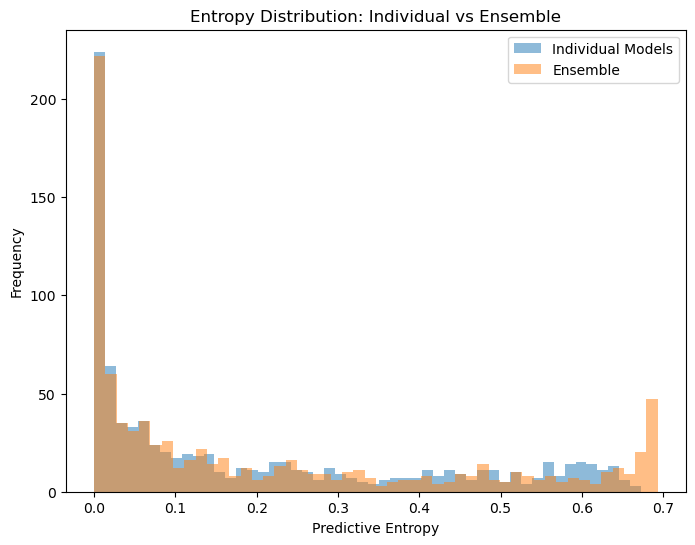

In [16]:
# Compute uncertainties for individual models
entropies_individual = []
for probs in all_probs:
    entropy_individual = -np.sum(probs * np.log(probs + 1e-9), axis=1)
    entropies_individual.append(entropy_individual) 

# Average individual entropies
mean_entropy_individual = np.mean(entropies_individual, axis=0)

# Plot comparison
plt.figure(figsize=(8, 6))
plt.hist(mean_entropy_individual, bins=50, alpha=0.5, label='Individual Models')
plt.hist(entropy, bins=50, alpha=0.5, label='Ensemble')
plt.title('Entropy Distribution: Individual vs Ensemble')
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.show()



Additional Tips:

- Interactive Visualizations: Use tools like Plotly or Bokeh for interactive plots that allow you to hover over data points to see exact values.
- Dimension Reduction: Apply techniques like t-SNE or UMAP to project high-dimensional data into 2D and color-code the points based on uncertainty.


In [17]:

# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=0)
# embeddings_2d = tsne.fit_transform(val_X.numpy())

# plt.figure(figsize=(8, 6))
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=entropy, cmap='viridis', alpha=0.7)
# plt.colorbar(label='Predictive Entropy')
# plt.title('t-SNE Projection Colored by Uncertainty')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.show()


- 	Thresholding: Set thresholds for uncertainty measures to flag or further investigate certain predictions.

Integrating Visualizations into Your Workflow:

1.	Run the ensemble_uncertainty Function:

mean_probs, variance_probs, entropy = ensemble_uncertainty(ensemble_models, val_X, device)


2.	Choose Appropriate Visualizations:
- For overall understanding, start with histograms.
- To explore relationships, use scatter plots.
- For calibration, use reliability diagrams.
- For data with spatial structure, consider heatmaps.
3.	Interpret the Results:
- High Variance/Entropy: Indicates where the model is uncertain; consider investigating these samples.
- Calibration Curves: Help you understand if the probabilities reflect true likelihoods.
- Misclassifications with High Uncertainty: Potentially difficult samples or outliers.
4.	Refine the Model:
- Use insights from visualizations to improve data preprocessing, model architecture, or training strategies.
- Consider collecting more data in regions of high uncertainty.

Example Workflow:

Here’s how you might put it all together:


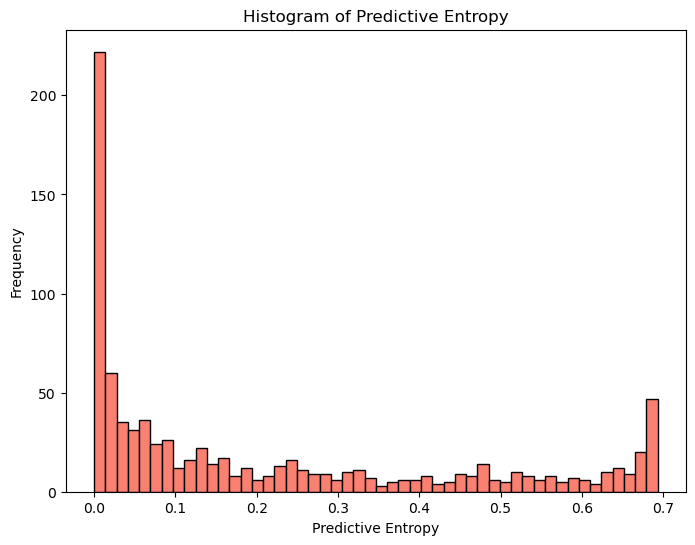

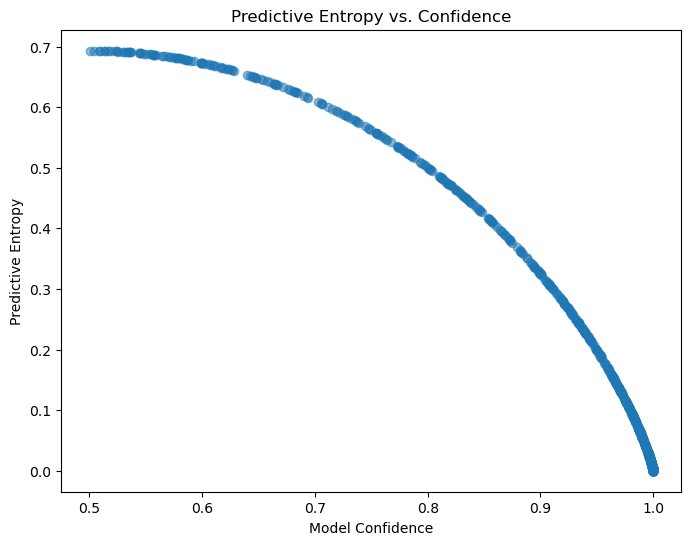

In [18]:
all_probs = ensemble_probs['probs']

# Predictive mean (averaged probabilities)
mean_probs = ensemble_probs['mean']

# Predictive variance (epistemic uncertainty)
variance_probs = ensemble_probs['var']

# Predictive entropy
entropy = ensemble_probs['entropy']

# Step 2: Visualize Histogram of Predictive Entropy
plt.figure(figsize=(8, 6))
plt.hist(entropy, bins=50, color='salmon', edgecolor='black')
plt.title('Histogram of Predictive Entropy')
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.show()

# Step 3: Scatter Plot of Confidence vs. Predictive Entropy
confidence = np.max(mean_probs, axis=1)
plt.figure(figsize=(8, 6))
plt.scatter(confidence, entropy, alpha=0.5)
plt.title('Predictive Entropy vs. Confidence')
plt.xlabel('Model Confidence')
plt.ylabel('Predictive Entropy')
plt.show()

# Step 4: Reliability Diagram
# from sklearn.calibration import calibration_curve

# prob_pos = mean_probs[:, 1]
# fraction_of_positives, mean_predicted_value = calibration_curve(val_y.numpy(), prob_pos, n_bins=10)

# plt.figure(figsize=(8, 6))
# plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Ensemble")
# plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
# plt.title('Reliability Diagram')
# plt.xlabel('Mean Predicted Probability')
# plt.ylabel('Fraction of Positives')
# plt.legend()
# plt.show()



By employing these visualization techniques, you’ll gain a deeper understanding of where and why your model is uncertain. This can guide you in making informed decisions about model improvements, data collection, or even deploying the model in real-world scenarios where uncertainty estimation is critical.

Remember, the key is not just to compute uncertainty measures but to interpret them in the context of your specific problem and data.

# Distilation

Certainly! Knowledge distillation is a technique where a smaller model (student) is trained to replicate the behavior of a larger model or an ensemble of models (teacher). In your case, you can distill the knowledge from the ensemble of MLP models into a single MLP model.

Here’s how you can proceed:
	1.	Generate Soft Targets: Use the ensemble to generate probability distributions (soft labels) for the training data.
	2.	Train the Student Model: Train a single MLP model using these soft targets, minimizing the difference between the student’s outputs and the soft targets from the ensemble.
	3.	Implement Distillation Loss: Use a combination of cross-entropy loss with the true labels and Kullback-Leibler (KL) divergence loss with the soft labels.

Below is the complete code integrating knowledge distillation into your existing setup.

Step-by-Step Guide

1. Generate Soft Targets from the Ensemble

- Use the trained ensemble models to generate the averaged probabilities (mean of softmax outputs) for the training data.

2. Define the Student Model

- Create a new MLP model that will serve as the student.

3. Implement the Distillation Loss Function

- Use a custom loss function that combines the standard cross-entropy loss with the KL divergence between the student’s outputs and the soft targets.
- Introduce a temperature parameter T to soften the probabilities.

4. Train the Student Model

- Train the student model on the training data using the distillation loss.
- Monitor the validation performance.



Epoch 1/100, Loss: 0.1965
Validation -- Accuracy: 0.8612, NLL: 0.3456, ECE: 0.0338, F1 Score: 0.8610
Epoch 2/100, Loss: 0.0921
Validation -- Accuracy: 0.8693, NLL: 0.3314, ECE: 0.0346, F1 Score: 0.8689
Epoch 3/100, Loss: 0.0659
Validation -- Accuracy: 0.8716, NLL: 0.3300, ECE: 0.0368, F1 Score: 0.8715
Epoch 4/100, Loss: 0.0517
Validation -- Accuracy: 0.8658, NLL: 0.3284, ECE: 0.0461, F1 Score: 0.8656
Epoch 5/100, Loss: 0.0438
Validation -- Accuracy: 0.8647, NLL: 0.3315, ECE: 0.0504, F1 Score: 0.8645
No improvement for 1 consecutive epoch(s).
Epoch 6/100, Loss: 0.0399
Validation -- Accuracy: 0.8601, NLL: 0.3379, ECE: 0.0482, F1 Score: 0.8599
No improvement for 2 consecutive epoch(s).
Epoch 7/100, Loss: 0.0374
Validation -- Accuracy: 0.8658, NLL: 0.3452, ECE: 0.0463, F1 Score: 0.8655
No improvement for 3 consecutive epoch(s).
Epoch 8/100, Loss: 0.0356
Validation -- Accuracy: 0.8601, NLL: 0.3413, ECE: 0.0528, F1 Score: 0.8599
No improvement for 4 consecutive epoch(s).
Epoch 9/100, Loss: 0

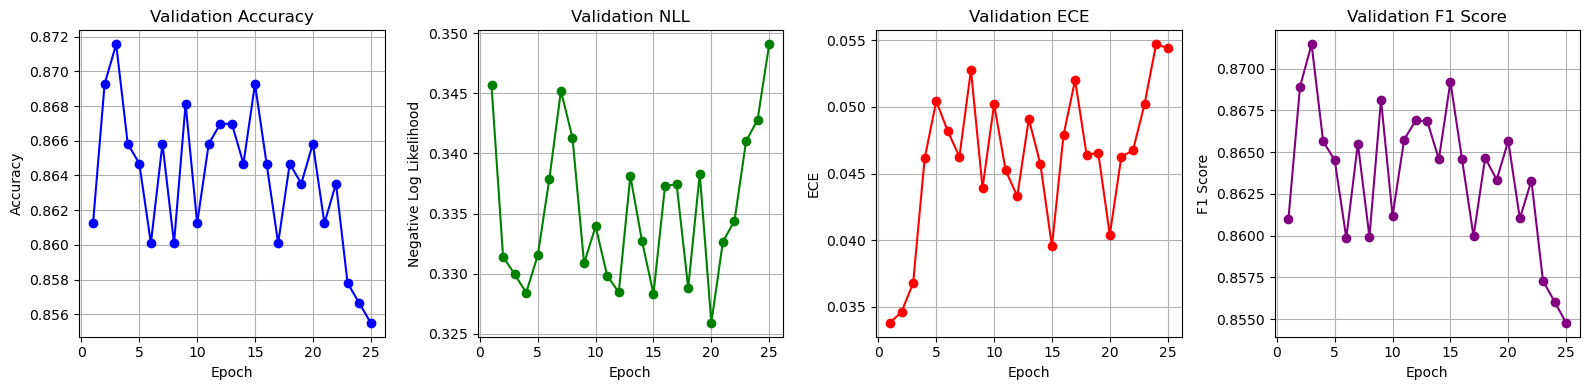

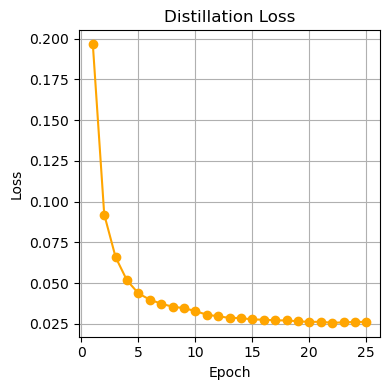

In [19]:
# Ignore warnings of a specific category
warnings.filterwarnings('ignore', category=UserWarning)

student_model, loss_plot = train_student_model(
    MLP, train_em, train_la, 
    val_em, val_la, ensemble_models, 
    epochs=100, T=1.0, alpha=0.1, patience=5)

# Re-enable warnings by clearing or overriding the filter
warnings.filterwarnings('default', category=UserWarning)


## Eval on test set

In [20]:
metrics = evaluate_models(test_em, test_la, student_model, ensemble_models, device, batch_size=2024)

Student -- Accuracy: 0.9073, NLL: 0.2397, ECE: 0.0132, F1 Score: 0.9073
Individual -- Accuracy: 0.9068, NLL: 0.2384, ECE: 0.0144, F1 Score: 0.9067
Ensemble -- Accuracy: 0.9105, NLL: 0.2284, ECE: 0.0117, F1 Score: 0.9105



Explanation

- Temperature (T): A higher temperature softens the probability distribution, making the model pay more attention to less probable classes. It’s common to set T=2.0 or higher.
- Alpha (alpha): Balances the importance between the hard targets (true labels) and the soft targets (ensemble outputs). Adjusting alpha allows you to emphasize either the true labels or the knowledge from the ensemble.
- DataLoader Modification: We ensure that the data loader does not shuffle the data so that the indices of the soft targets align with the batches.

Notes

- Device Management: Ensure that all tensors and models are on the same device during training and inference.
- Memory Considerations: Storing soft targets for the entire dataset may consume significant memory for large datasets. If this is an issue, consider generating soft targets on-the-fly during training.
- Performance Evaluation: After training, compare the performance of the student model with the ensemble and individual models to assess the effectiveness of distillation.



In [21]:
metrics = evaluate_models(imdb_test_em, imdb_test_la, student_model, ensemble_models, device, batch_size=2024)

Student -- Accuracy: 0.8832, NLL: 0.3111, ECE: 0.0357, F1 Score: 0.8831
Individual -- Accuracy: 0.8840, NLL: 0.3167, ECE: 0.0358, F1 Score: 0.8839
Ensemble -- Accuracy: 0.8852, NLL: 0.3037, ECE: 0.0338, F1 Score: 0.8851
